# Импортируемые библиотеки

In [49]:
import random
import itertools
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Подготовка данных

In [2]:
''' This script is used to create a training/validation/test split of the data stored in the UECFood-256 dataset format '''
   
#################################################
# Parameters ( IMPORTANT!: do NOT use spaces in paths or in image names! )
path = 'UECFOOD256';
categories = 'category.txt'
bbox_files = 'bb_info.txt'

imgs_format = 'jpg'

split = [0.7, 0.1, 0.2] # [train, val, test] percentages

files_split = ['train_list.csv', 'val_list.csv', 'test_list.csv']

# Localization result
generate_localization = True
path_localization = path

    
#################################################
    
# Read categories ids and names
print ("Reading categories")
category_ids = []
category_names = []
with open(path+'/'+categories, 'r') as list_:
    for i,line in enumerate(list_):
        if(i > 0): # skip header
            line = line.rstrip('\n')
            line = line.split('\t')
            category_ids.append(int(line[0]))
            category_names.append(line[1])
            
    
# Read list of images from each category
print ("Reading images and their bboxes from each category")
categories_images = []
categories_bbox_info = []
for id_pos, id in enumerate(category_ids):
    # Create empty list for images list and bbox info
    categories_images.append([])
    categories_bbox_info.append([])
        
    # Read file
    imgs_file_list = path+'/'+str(id)+'/'+bbox_files
    with open(imgs_file_list, 'r') as list_:
        for i,line in enumerate(list_):
            if(i > 0): # skip header
                line = line.rstrip('\n')
                line = line.split(' ')
                categories_images[id_pos].append(line[0])
                line = line[1:]
                for j,l in enumerate(line):
                    line[j] = float(l)
                categories_bbox_info[id_pos].append(line)
    
    
# Split categories in train/val/test
print ("Splitting categories in train/val/test")
train_list = [] # all lists store image ids (names)
val_list = []
test_list = []
for id_pos, id in enumerate(category_ids):
    # Divide number of samples
    n_imgs = len(categories_images[id_pos])
    n_test = int(np.floor(n_imgs*split[2]))
    n_val = int(np.floor(n_imgs*split[1]))
    n_train = n_imgs - (n_test + n_val)
        
    # Shuffle samples
    shuffled = random.sample(categories_images[id_pos], n_imgs)
        
    train_list.append(shuffled[:n_train])
    val_list.append(shuffled[n_train:n_train+n_val])
    test_list.append(shuffled[n_train+n_val:])
    
    
    
# Get train/val/test complete lists from any category
print ("Joining all train, all val and all test samples")
all_train_list = list(np.unique(list(itertools.chain(*train_list))))
all_val_list = list(np.unique(list(itertools.chain(*val_list))))
all_test_list = list(np.unique(list(itertools.chain(*test_list))))
    
    
# Solve splits overlaps (giving preference in the order val(1), test(2), train(3))
print ("Solving splits overlaps")
i = 0
while(i < len(all_train_list)): # give priority to val and test over train
    if(all_train_list[i] in all_val_list): # training sample is in val set too
        all_train_list.pop(i)
    elif(all_train_list[i] in all_test_list): # training sample is in test set too
        all_train_list.pop(i)    
    else:
        i += 1
            
i = 0
while(i < len(all_test_list)): # give priority to val over test
    if(all_test_list[i] in all_val_list): # test sample is in val set too
        all_test_list.pop(i)
    else:
        i += 1
            
    
    
#################################################
#    LOCALIZATION
#################################################    
    
if(generate_localization):
    print ("Writing localization split files")
    # Store localization split files
    if(not os.path.isdir(path_localization)):
        os.makedirs(path_localization)
        
    # Store file with classes
    file = open(path_localization +'/classes.csv', 'w')
    for c in category_names:
        file.write(c+'\n')
    file.close()
        
    ########### Training
    file = open(path_localization +'/'+ files_split[0], 'w')
    file.write('path_img category_id x1 y1 x2 y2\n')
    for img in all_train_list:
        # Find all occurrences of this image and their categories
        occurrences = []
        for id_pos, id in enumerate(category_ids):
            categories_images[id_pos]
            occ = [[path+'/'+str(id)+'/'+img+'.'+imgs_format, str(id)]+categories_bbox_info[id_pos][i] for i, elem in enumerate(categories_images[id_pos]) if elem==img]
            occurrences += occ
            
        # Write in file each occurrence found for the current image
        for occ in occurrences:
            path_img = occ[0]
            category_img = occ[1]
            bbox_img = str(occ[2])+' '+str(occ[3])+' '+str(occ[4])+' '+str(occ[5])
            file.write(path_img + ' ' + category_img + ' ' + bbox_img + '\n')
    file.close()
        
        ########### Val
    file = open(path_localization +'/'+ files_split[1], 'w')
    file.write('path_img category_id x1 y1 x2 y2\n')
    for img in all_val_list:
        # Find all occurrences of this image and their categories
        occurrences = []
        for id_pos, id in enumerate(category_ids):
            categories_images[id_pos]
            occ = [[path+'/'+str(id)+'/'+img+'.'+imgs_format, str(id)]+categories_bbox_info[id_pos][i] for i, elem in enumerate(categories_images[id_pos]) if elem==img]
            occurrences += occ
            
         # Write in file each occurrence found for the current image
        for occ in occurrences:
            path_img = occ[0]
            category_img = occ[1]
            bbox_img = str(occ[2])+' '+str(occ[3])+' '+str(occ[4])+' '+str(occ[5])
            file.write(path_img + ' ' + category_img + ' ' + bbox_img + '\n')
    file.close()
        
    ########### Test
    file = open(path_localization +'/'+ files_split[2], 'w')
    file.write('path_img category_id x1 y1 x2 y2\n')
    for img in all_test_list:
        # Find all occurrences of this image and their categories
        occurrences = []
        for id_pos, id in enumerate(category_ids):
            categories_images[id_pos]
            occ = [[path+'/'+str(id)+'/'+img+'.'+imgs_format, str(id)]+categories_bbox_info[id_pos][i] for i, elem in enumerate(categories_images[id_pos]) if elem==img]
            occurrences += occ
            
        # Write in file each occurrence found for the current image
        for occ in occurrences:
            path_img = occ[0]
            category_img = occ[1]
            bbox_img = str(occ[2])+' '+str(occ[3])+' '+str(occ[4])+' '+str(occ[5])
            file.write(path_img + ' ' + category_img + ' ' + bbox_img + '\n')
    file.close()
    
print ('Done!')

Reading categories
Reading images and their bboxes from each category
Splitting categories in train/val/test
Joining all train, all val and all test samples
Solving splits overlaps
Writing localization split files
Done!


# Загрузка данных:

In [33]:
df_category = pd.read_csv('UECFOOD256/category.csv', delimiter="\t", header=0)
df_val = pd.read_csv('UECFOOD256/val_list.csv', delimiter=" ", header=0)
df_test = pd.read_csv('UECFOOD256/test_list.csv', delimiter=" ", header=0)
df_train = pd.read_csv('UECFOOD256/train_list.csv', delimiter=" ", header=0)

In [34]:
df_test

,path_img,category_id,x1,y1,x2,y2
0,UECFOOD256/1/1.jpg,1,0.0,143.0,370.0,486.0
1,UECFOOD256/42/1.jpg,42,363.0,91.0,800.0,560.0
2,UECFOOD256/2/100.jpg,2,23.0,0.0,293.0,227.0
3,UECFOOD256/137/100037.jpg,137,100.0,36.0,428.0,283.0
4,UECFOOD256/123/100327.jpg,123,12.0,11.0,596.0,375.0
...,...,...,...,...,...,...
6914,UECFOOD256/10/997.jpg,10,18.0,24.0,300.0,224.0
6915,UECFOOD256/137/99776.jpg,137,36.0,48.0,457.0,325.0
6916,UECFOOD256/10/998.jpg,10,0.0,8.0,240.0,290.0
6917,UECFOOD256/102/998.jpg,102,36.0,39.0,544.0,402.0


In [35]:
df_train

,path_img,category_id,x1,y1,x2,y2
0,UECFOOD256/1/10.jpg,1,71.0,16.0,478.0,328.0
1,UECFOOD256/11/1000.jpg,11,11.0,6.0,236.0,203.0
2,UECFOOD256/137/100031.jpg,137,16.0,30.0,456.0,325.0
3,UECFOOD256/137/100060.jpg,137,45.0,28.0,488.0,399.0
4,UECFOOD256/114/10007.jpg,114,9.0,16.0,562.0,414.0
...,...,...,...,...,...,...
21029,UECFOOD256/137/99851.jpg,137,86.0,49.0,598.0,387.0
21030,UECFOOD256/137/99855.jpg,137,82.0,70.0,519.0,375.0
21031,UECFOOD256/118/9988.jpg,118,7.0,14.0,492.0,487.0
21032,UECFOOD256/10/999.jpg,10,0.0,0.0,480.0,360.0


In [36]:
df_val

,path_img,category_id,x1,y1,x2,y2
0,UECFOOD256/155/100163.jpg,155,20.0,37.0,484.0,481.0
1,UECFOOD256/123/100246.jpg,123,3.0,1.0,380.0,247.0
2,UECFOOD256/149/100296.jpg,149,10.0,10.0,495.0,481.0
3,UECFOOD256/153/100353.jpg,153,14.0,36.0,561.0,412.0
4,UECFOOD256/11/1004.jpg,11,16.0,0.0,215.0,152.0
...,...,...,...,...,...,...
3687,UECFOOD256/117/98902.jpg,117,10.0,6.0,397.0,299.0
3688,UECFOOD256/36/99.jpg,36,310.0,174.0,626.0,448.0
3689,UECFOOD256/99/99.jpg,99,10.0,176.0,308.0,442.0
3690,UECFOOD256/10/990.jpg,10,0.0,0.0,800.0,600.0


# Анализ данных

In [37]:
df_category['id'] = df_category['id\tname'].apply(lambda x: str(x).split("\t")[0])
df_category['name'] = df_category['id\tname'].apply(lambda x: str(x).split("\t")[1])
df_category.drop('id\tname', axis =1, inplace=True)

## Уникальные категории

In [47]:
df_category

,id,name
0,1,rice
1,2,eels on rice
2,3,pilaf
3,4,chicken-'n'-egg on rice
4,5,pork cutlet on rice
...,...,...
251,252,winter melon soup
252,253,steamed spareribs
253,254,chinese pumpkin pie
254,255,eight treasure rice


## Группировка данных в test/train/val для подсчета количества по категориям

In [9]:
count_df_1 = df_val.groupby('category_id').size().reset_index(name='count')
df_all = pd.concat([df_category, count_df_1], axis=1)

In [10]:
count_df_2 = df_train.groupby('category_id').size().reset_index(name='count_2')
df_all = pd.concat([df_all, count_df_2], axis=1)

In [11]:
count_df_3 = df_test.groupby('category_id').size().reset_index(name='count_3')
df_all = pd.concat([df_all, count_df_3], axis=1)
df_all.drop('category_id', axis =1, inplace=True)

In [12]:
df_all['sum_count'] = df_all['count'] + df_all['count_2'] + df_all['count_3']

In [46]:
df_all.head()

,id,name,count,count_2,count_3,sum_count
0,1,rice,138,277,211,626
1,2,eels on rice,15,89,26,130
2,3,pilaf,11,80,24,115
3,4,chicken-'n'-egg on rice,16,82,23,121
4,5,pork cutlet on rice,19,97,35,151


In [14]:
df_all[df_all['sum_count'].isna()]

,id,name,count,count_2,count_3,sum_count


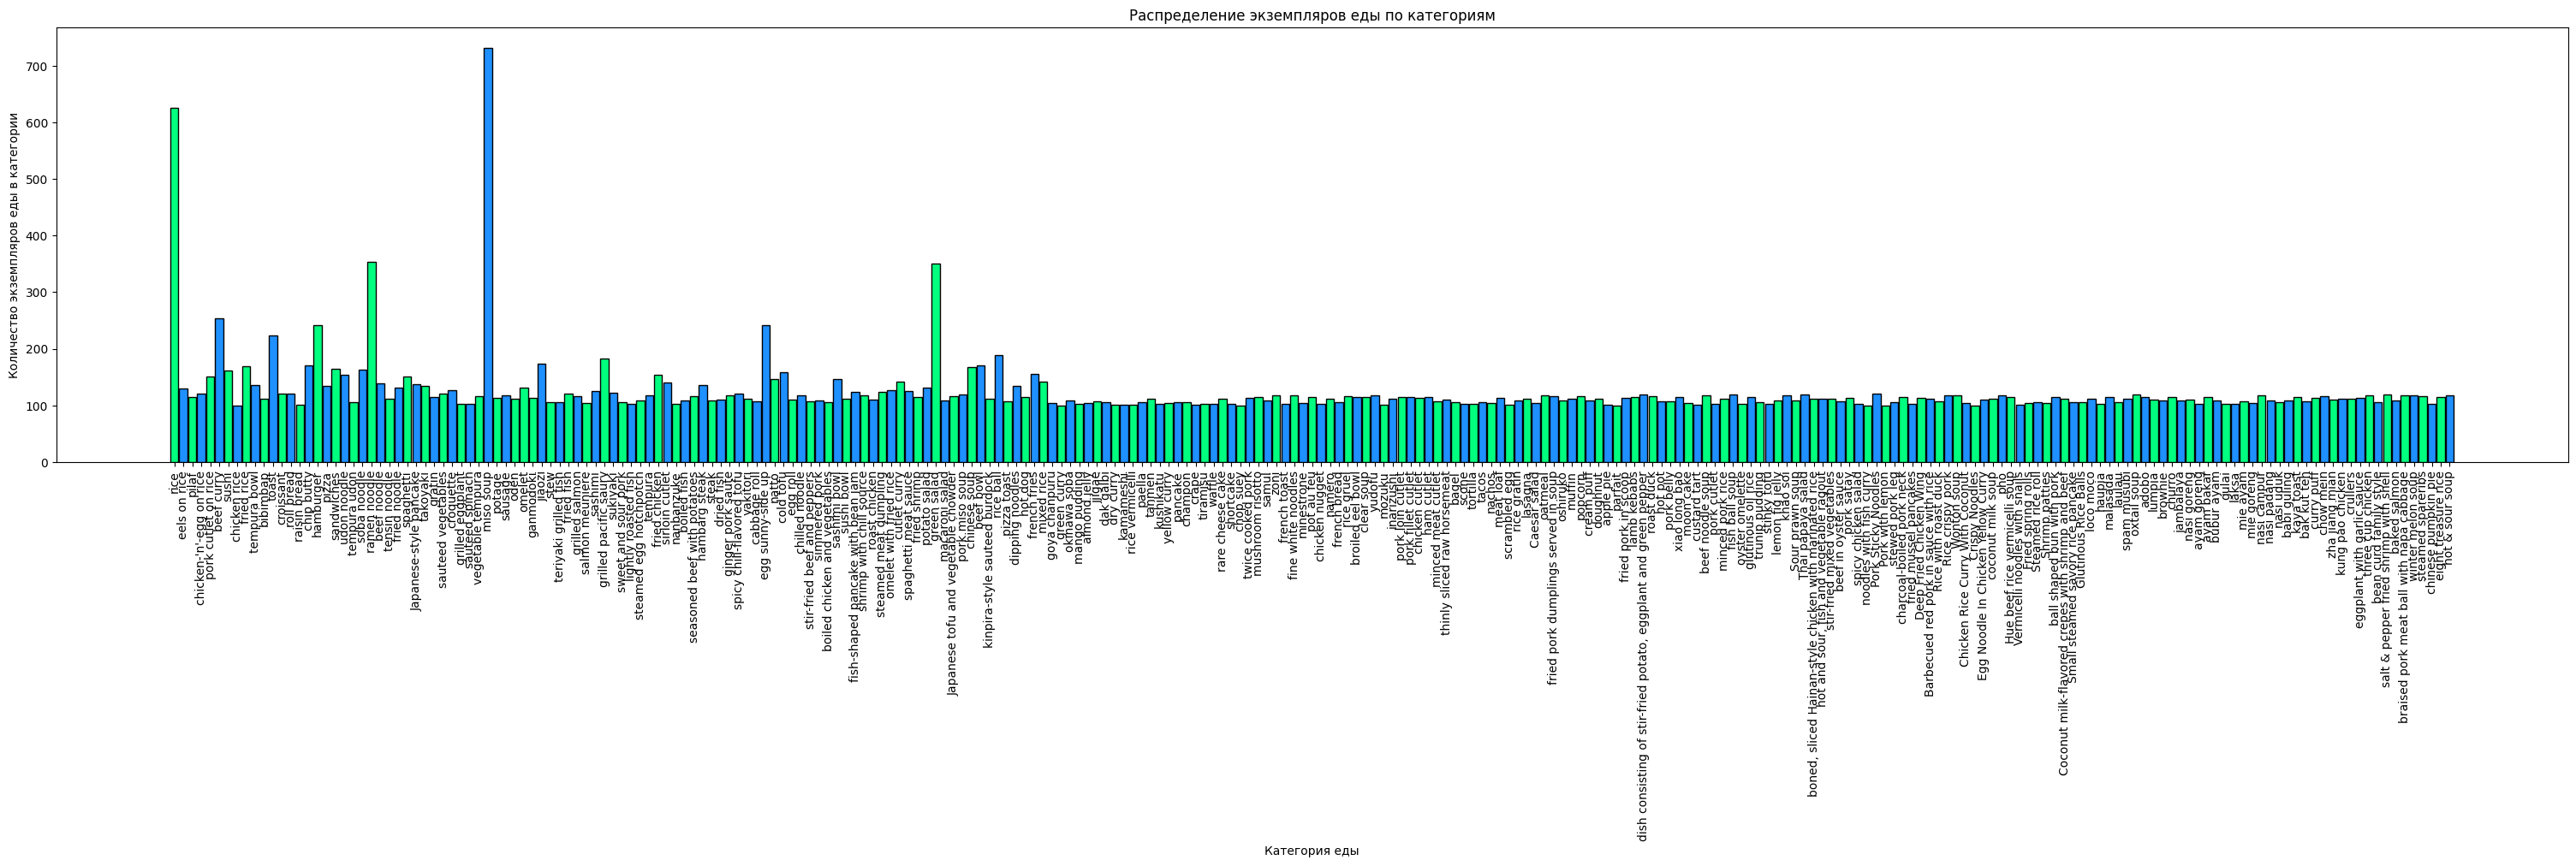

In [59]:
plt.figure(figsize=(30,10))
plt.bar(df_all["name"], df_all["sum_count"], color = ["springgreen", "dodgerblue"], width = 0.9, edgecolor='black')

plt.xlabel("Категория еды")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.ylabel("Количество экземпляров еды в категории")
plt.title("Распределение экземпляров еды по категориям");
plt.show()

In [72]:
df_all[df_all["sum_count"] == df_all.sum_count.max()]

,id,name,count,count_2,count_3,sum_count
35,36,miso soup,160,334,237,731


In [73]:
df_all[df_all["sum_count"] == df_all.sum_count.min()]

,id,name,count,count_2,count_3,sum_count
7,8,chicken rice,10,66,24,100
100,101,green curry,13,62,25,100
120,121,chop suey,12,69,19,100
162,163,parfait,10,70,20,100
190,191,noodles with fish curry,10,70,20,100
192,193,Pork with lemon,10,70,20,100
202,203,Crispy Noodles,10,70,20,100


## Вывод:

Больше всего экземпляров еды в категории misco_soup - 731, меньше всего в категориях: chicken rice, green curry, chop suey, parfait, noodles with fish curry, Pork with lemon, Crispy Noodles

## Анализ средней площади картинок по категориям

In [16]:
df_train['s_bb'] = df_train.apply(lambda x: abs(x['x1']-x['x2'])*abs(x['y1']-x['y2']), axis=1)
tr_gr = df_train.groupby(['category_id'], as_index=False).agg(
    s_bb_mean = ('s_bb', 'mean'))

In [45]:
tr_gr.head()

,category_id,s_bb_mean
0,1,83760.794224
1,2,91593.808989
2,3,84740.187500
3,4,87409.902439
4,5,88445.206186


In [18]:
df_test['s_bb'] = df_test.apply(lambda x: abs(x['x1']-x['x2'])*abs(x['y1']-x['y2']), axis=1)
te_gr = df_test.groupby(['category_id'], as_index=False).agg(
    s_bb_mean = ('s_bb', 'mean'))

In [44]:
te_gr.head()

,category_id,s_bb_mean
0,1,58268.777251
1,2,83181.192308
2,3,70507.166667
3,4,113148.782609
4,5,92580.914286


In [20]:
df_val['s_bb'] = df_val.apply(lambda x: abs(x['x1']-x['x2'])*abs(x['y1']-x['y2']), axis=1)
vl_gr = df_val.groupby(['category_id'], as_index=False).agg(
    s_bb_mean = ('s_bb', 'mean'))

In [43]:
vl_gr.head()

,category_id,s_bb_mean
0,1,56976.173913
1,2,88826.200000
2,3,69756.727273
3,4,125413.062500
4,5,115991.947368


In [39]:
df_all_s_bb = df_category.copy()

In [40]:
df_all_s_bb['s_bb_mean'] = tr_gr['s_bb_mean'] + te_gr['s_bb_mean'] + vl_gr['s_bb_mean']

In [42]:
df_all_s_bb.head()

,id,name,s_bb_mean
0,1,rice,199005.745388
1,2,eels on rice,263601.201296
2,3,pilaf,225004.081439
3,4,chicken-'n'-egg on rice,325971.747548
4,5,pork cutlet on rice,297018.067840


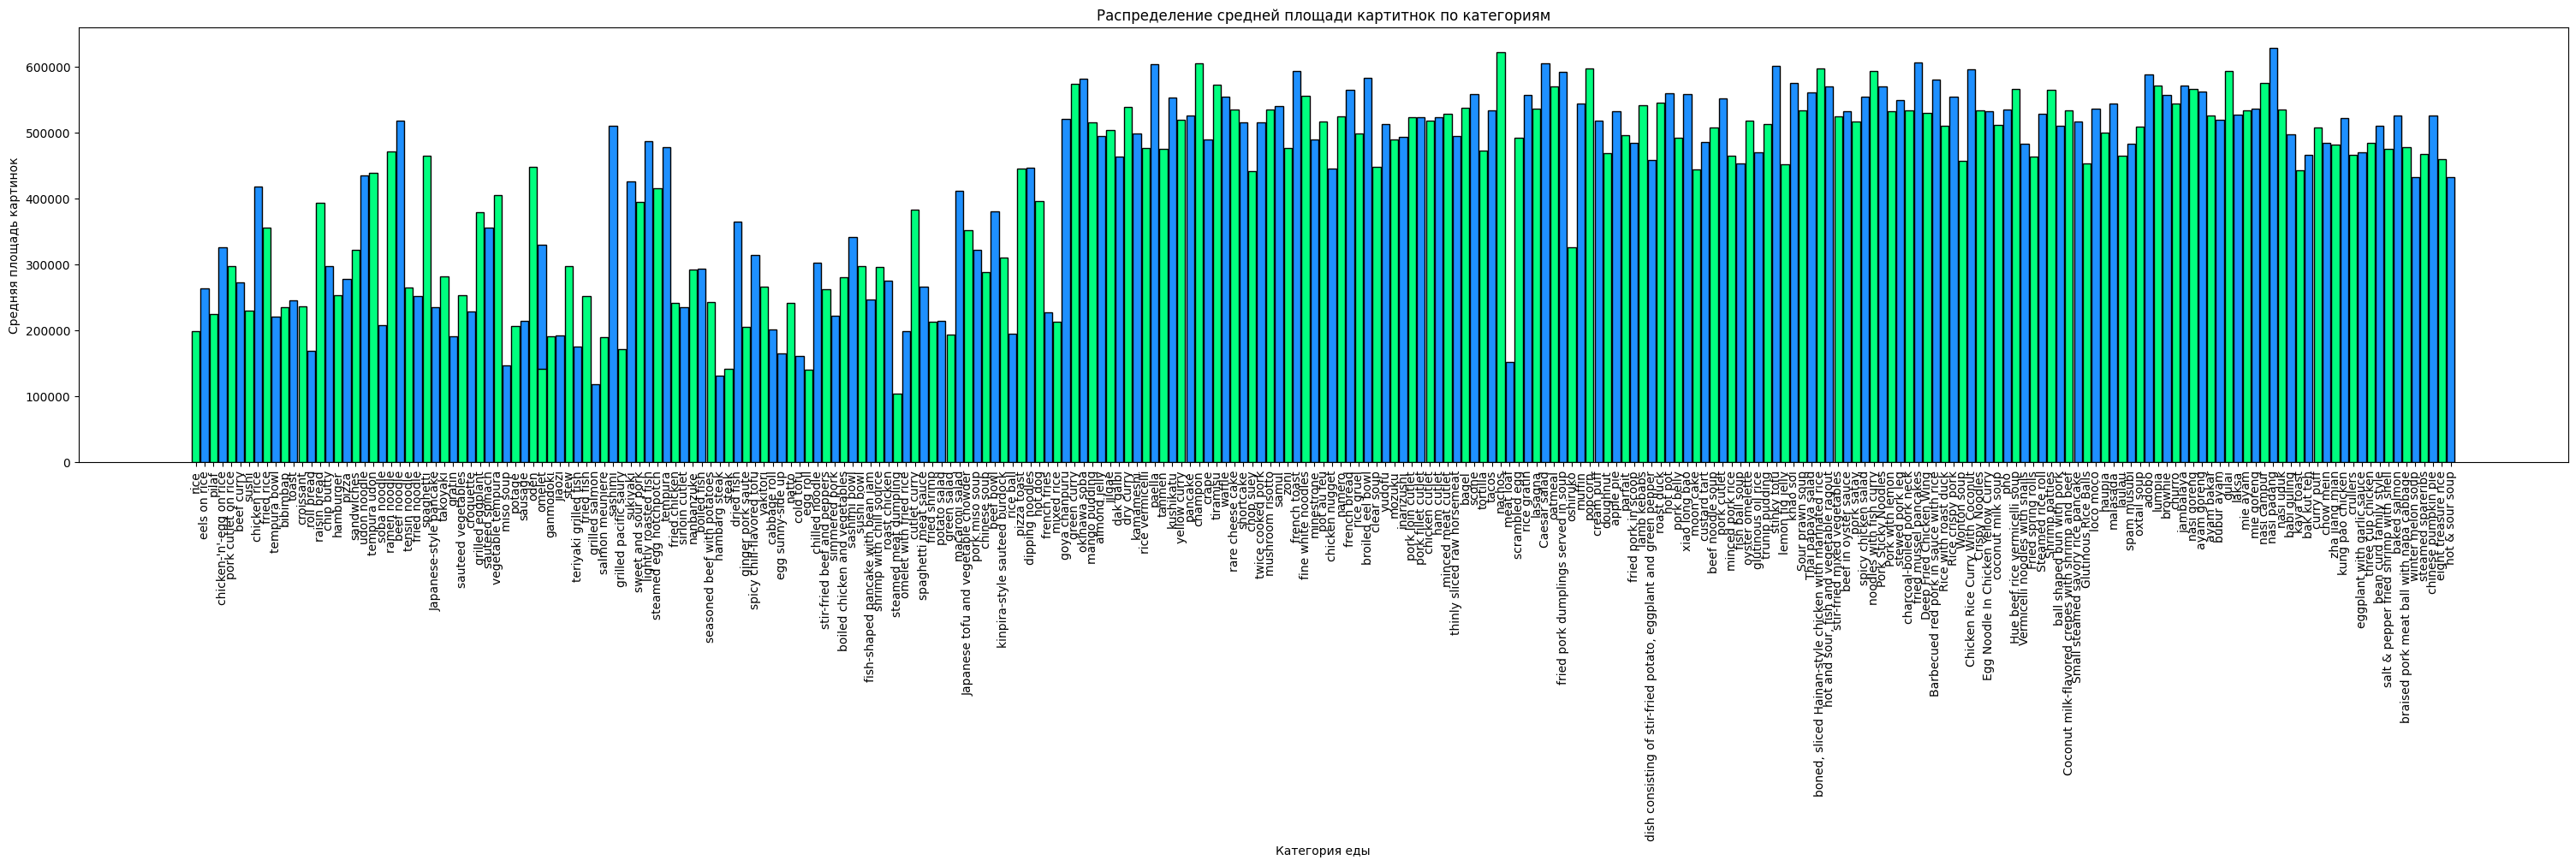

In [48]:
plt.figure(figsize=(30,10))
plt.bar(df_all_s_bb["name"], df_all_s_bb["s_bb_mean"], color = ["springgreen", "dodgerblue"], width = 0.9, edgecolor='black')

plt.xlabel("Категория еды")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.ylabel("Средняя площадь картинок")
plt.title("Распределение средней площади картитнок по категориям");
plt.show()

In [70]:
df_all_s_bb[df_all_s_bb["s_bb_mean"] == df_all_s_bb.s_bb_mean.max()]

,id,name,s_bb_mean
235,236,nasi padang,628985.281319


In [71]:
df_all_s_bb[df_all_s_bb["s_bb_mean"] == df_all_s_bb.s_bb_mean.min()]

,id,name,s_bb_mean
80,81,steamed meat dumpling,103451.315934


## Вывод:

Самые большие картинки в nasi padang (т.к. их не наибольшее количество, можно сделать такой вывод), самые маленькие картинки в steamed meat dumpling